In [1]:
%load_ext autoreload

In [1]:
model_file = "model_ACAT21.py"
config_json = "training_config_awk.json"

In [2]:
import awk_data
import tensorflow as tf
import loader
import argparse 
from collections import defaultdict
import os, json
import importlib.util
from time import time
import numpy as np
from plotting import * 
import plot_loss

config = json.load(open(config_json))

config['activation'] = tf.keras.activations.get(config['activation'])

# Checking hardware
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
gpus =  tf.config.list_physical_devices('GPU')

# if len(gpus) ==1 :
#     print("Using 1 GPU")
#     tf.config.experimental.set_memory_growth(gpus[0], enable=True)
#     strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# elif len(gpus):
#     print("Using {} GPUs".format(len(gpus)))
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, enable=True)
#     strategy = tf.distribute.MirroredStrategy()
# else:
#     strategy = tf.distribute.OneDeviceStrategy("cpu:0")
if len(gpus) >=1 :
    print("Using 1 GPU")
    #tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")


##################
# Prepare the output folder
def get_unique_run():
    previous_runs = os.listdir(config["models_path"])
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

if not os.path.isdir(config["models_path"]):
    os.makedirs(config["models_path"])

name =  'run_{:02}'.format(get_unique_run())

outdir = config["models_path"] + "/"+ name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print("Model output folder: ", outdir)

############################3
#Copying the config file and model file in the output dir:
os.system("cp {} {}".format(config_json, outdir))
os.system("cp {} {}".format(model_file, outdir))


version=2.1.0, CUDA=True, GPU=True
Using 1 GPU
Model output folder:  /work/dvalsecc/Clustering/models_archive/gcn_models/ACAT2021_v2//run_70


2022-09-22 12:34:32.874133: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-22 12:34:37.216864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-22 12:34:37.217620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-22 12:34:37.222421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 2 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBan

0

In [3]:
###########################
## Loading the datasets
print(">>> Loading datasets")

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))
test_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["validation"]))
# Create training and validation
ds_train = train_ds.prefetch(200).repeat(config['nepochs'])
ds_test  = test_ds.prefetch(200).repeat(config['nepochs'])

>>> Loading datasets
((tf.float32, tf.float32, tf.float32, tf.int64, tf.float32, tf.float32), (tf.int64, tf.float32, tf.float32, tf.float32, tf.float32), (tf.float32,))
((tf.float32, tf.float32, tf.float32, tf.int64, tf.float32, tf.float32), (tf.int64, tf.float32, tf.float32, tf.float32, tf.float32), (tf.float32,))


2022-09-22 12:34:37.372388: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-22 12:34:37.394421: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200115000 Hz
2022-09-22 12:34:37.400446: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5595f6300450 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-22 12:34:37.400494: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-22 12:34:38.575156: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5595f638a1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-22 12:34:38.575223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2022-09-22 12:34:38.

In [ ]:
############### 
# Loading the model file
 # Load model modules
spec = importlib.util.spec_from_file_location("model", model_file)
model_lib = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model_lib)

tf.keras.backend.clear_session()
# Construction of the model in the strategy scope
with strategy.scope():
    print(">>> Creating the model")
    # Build the model with all the configs
    model = model_lib.DeepClusterGN(**config)

    #optimizer
    if config['opt'] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])

    #compile the model
    model.compile(optimizer=opt)
    model.set_metrics()

    for X, y ,w  in ds_train:
        # Load the model
        ypred = model(X, training=False)
        #l = custom_loss(y, ypred)
        break

    model.summary()
    

>>> Creating the model
ERROR! Session/line number was not unique in database. History logging moved to new session 487


2022-09-22 12:35:14.407778: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 12:35:14.839418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-09-22 12:35:16.014217: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/work/dvalsecc/miniconda3/envs/clustering3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23605/1258610601.py", line 25, in <module>
    ypred = model(X, training=False)
  File "/work/dvalsecc/miniconda3/envs/clustering3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 822, in __call__
    outputs = self.call(cast_inputs, *args, **kwargs)
  File "model_ACAT21.py", line 632, in call
    cl_X, coord, adj, output_rechits,coord_att_ws = self.graphbuild(cl_X_initial, cl_hits, mask_rechits, mask_cls, training)
  File "/work/dvalsecc/miniconda3/envs/clustering3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 822, in __call__
    outputs = self.call(cast_inputs, *args, **kwargs)
  File "model_ACAT21.py", line 489, in call
    output_rechits, (debug) = self.rechitsGC

In [17]:
history = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=config['nepochs'],
        steps_per_epoch=3, 
        validation_steps=3,
        verbose=2,
    )

Epoch 1/3


2022-09-22 11:20:52.311865: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_44"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: 15
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 6
        }
      }
      shape {
        dim {


0.173596799
0.192695349
0.170938492


2022-09-22 11:21:07.979263: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_89"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: 15
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 6
        }
      }
      shape {
        dim {


3/3 - 24s - loss: 21.6032 - loss_clusters: 0.1791 - loss_windows: 1.0218 - loss_softF1: 0.8626 - loss_en_resol: 0.3980 - loss_en_softF1: 0.4592 - loss_en_regr: 1131.6947 - val_loss: 17.7833 - val_loss_clusters: 0.1451 - val_loss_windows: 0.5793 - val_loss_softF1: 0.6132 - val_loss_en_resol: 0.3931 - val_loss_en_softF1: 0.4557 - val_loss_en_regr: 1047.1036 - 24s/epoch - 8s/step
Epoch 2/3
0.185970128
0.178496212
0.178051636
3/3 - 7s - loss: 19.8376 - loss_clusters: 0.1808 - loss_windows: 0.6298 - loss_softF1: 0.8425 - loss_en_resol: 0.3243 - loss_en_softF1: 0.3989 - loss_en_regr: 1020.3561 - val_loss: 16.6382 - val_loss_clusters: 0.1501 - val_loss_windows: 0.3145 - val_loss_softF1: 0.5889 - val_loss_en_resol: 0.2760 - val_loss_en_softF1: 0.3515 - val_loss_en_regr: 993.3220 - 7s/epoch - 2s/step
Epoch 3/3


Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/multiprocessing/process.py", line 108, 

0.168071017


KeyboardInterrupt: 

In [8]:
loss_en_resol, loss_en_softF1 = energy_loss(y, y_pred, w[0],1.0)

In [9]:
loss_en_resol

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [43]:
with tf.GradientTape() as tape:
    y_pred = model(X, training=True)  # Forward pass
    # Compute our own loss
    loss_clusters = clusters_classification_loss(y, y_pred, w[0])
    loss_softF1 =  soft_f1_score(y,y_pred, w[0], 1.0)
    loss_windows = window_classification_loss(y, y_pred, w[0])
    #loss_en_resol, loss_en_softF1 = energy_loss(y, y_pred, w[0],1.0)
    #loss_en_regr = energy_regression_loss(y, y_pred, w[0])
    loss =  model.loss_weights["clusters"] * loss_clusters +\
        model.loss_weights["window"] * loss_windows + \
        model.loss_weights["softF1"] * loss_softF1 + \
        sum(model.losses)
    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

In [44]:
(dense_clclass, dense_windclass, en_regr_factor),  mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = y        
class_loss = tf.keras.losses.binary_crossentropy(y_clclass[:,:,tf.newaxis], dense_clclass, from_logits=True) * mask_cls
reduced_loss = tf.reduce_sum(tf.reduce_mean(class_loss, axis=-1) * w[0]) / tf.reduce_sum(w[0])
# This should be replaced by the mean over the not masked elements

In [24]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = y
y_target = tf.cast(y_clclass, tf.float32)[:,:,tf.newaxis]
cl_en = Et = cl_X[:,:,0:1]
En_sim_good = y_metadata[:,-1]
pred_prob = tf.nn.sigmoid(dense_clclass)

sel_en = tf.squeeze(tf.reduce_sum(cl_en * pred_prob , axis=1))
en_resolution_loss =  tf.reduce_sum(tf.square( (sel_en/En_sim_good) - 1) * w[0] ) / tf.reduce_sum(w[0]) 
#soft f1 style loss
tp = tf.reduce_sum(cl_en* pred_prob * y_target, axis=1)
fn = tf.reduce_sum(cl_en* (1 - pred_prob) * y_target, axis=1)
fp = tf.reduce_sum(cl_en* pred_prob * (1 - y_target), axis=1)
beta = 0.5
soft_f1_loss = 1 - ((1 + beta**2) * tp)/ ( (1+beta**2)*tp + beta* fn + fp + 1e-16)
reduced_f1 = tf.reduce_sum(tf.squeeze(soft_f1_loss) * w[0])  / tf.reduce_sum(w[0]) 

In [8]:
import awkward as ak

df = ak.from_parquet(config["dataset_conf"]["training"]["input_folders"][0], lazy=True)

(array([ 52709., 113004., 120649., 121921., 121264., 121061., 119187.,
        118122., 115305.,  74500.]),
 array([1.21495657e-03, 9.93404497e+00, 1.98668750e+01, 2.97997050e+01,
        3.97325350e+01, 4.96653650e+01, 5.95981950e+01, 6.95310250e+01,
        7.94638550e+01, 8.93966850e+01, 9.93295151e+01]),
 <BarContainer object of 10 artists>)

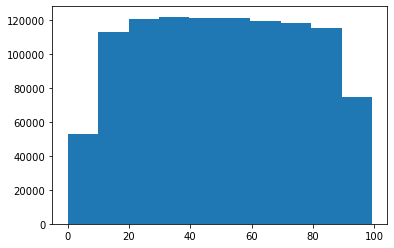

In [15]:
plt.hist(df.window_metadata.et_true_sim)